<a href="https://colab.research.google.com/github/Ivan8Garcia/Proyecto_NoCountry/blob/main/Proyecto_Aerolineas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CARGA OPTIMIZADA DEL DATASET

###Cargar el archivo sin romper Colab, reduciendo peso desde el inicio, leyendo solo lo necesario para el MVP

In [ ]:
# conectar a Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

cols = [
    "FL_DATE",
    "AIRLINE",
    "ORIGIN",
    "DEP_TIME",
    "DEP_DELAY",
    "TAXI_OUT",
    "DISTANCE",
    "CANCELLED"
]

ruta = "/content/drive/MyDrive/Colab Notebooks/Hackaton/Datos/flights_sample_3m.csv"

df = pd.read_csv(
    ruta,
    usecols=cols,
    low_memory=False
)

df.shape


(3000000, 8)

Para comenzar, cargamos el dataset de vuelos de forma optimizada, seleccionando únicamente las variables necesarias para la predicción. Esto nos permitió reducir el peso del archivo y trabajar de manera eficiente, manteniendo únicamente información disponible antes del despegue.

#Limpieza inicial y reducción del dataset

In [ ]:
  # Eliminar vuelos cancelados
df = df[df["CANCELLED"] == 0]

# Eliminar filas con datos críticos faltantes
df = df.dropna(subset=["DEP_DELAY", "DEP_TIME", "TAXI_OUT"])

df.shape


(2920860, 8)

En esta etapa realizamos una limpieza inicial del dataset, eliminando vuelos cancelados y registros incompletos. Esto nos permitió trabajar únicamente con vuelos que efectivamente despegaron y con información suficiente para entrenar un modelo predictivo confiable.

#Creación de la variable objetivo (Retrasado)

In [ ]:
# Crear variable objetivo: retrasado (1) o puntual (0)
df["RETRASADO"] = (df["DEP_DELAY"] > 15).astype(int)

# Ver distribución de la variable objetivo
df["RETRASADO"].value_counts(normalize=True)


,proportion
RETRASADO,
0,0.824363
1,0.175637


Definimos la variable objetivo utilizando un criterio estándar de la industria: un vuelo se considera retrasado si despega con más de 15 minutos de demora. Observamos un desbalance natural en los datos, donde la mayoría de vuelos son puntuales, lo cual refleja el comportamiento real del sistema aéreo

#Ingeniería de variables temporales

In [ ]:
# Convertir fecha a datetime
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

# Día de la semana (0=lunes, 6=domingo)
df["DAY_OF_WEEK"] = df["FL_DATE"].dt.dayofweek

# Indicador de fin de semana
df["IS_WEEKEND"] = df["DAY_OF_WEEK"].isin([5, 6]).astype(int)

# Convertir hora programada de salida a hora del día
df["DEP_HOUR"] = (df["DEP_TIME"] // 100).astype("Int64")

df[["FL_DATE", "DAY_OF_WEEK", "IS_WEEKEND", "DEP_HOUR"]].head()


,FL_DATE,DAY_OF_WEEK,IS_WEEKEND,DEP_HOUR
0,2019-01-09,2,0,11
1,2022-11-19,5,1,21
2,2022-07-22,4,0,10
3,2023-03-06,0,0,16
4,2020-02-23,6,1,18


A partir de la fecha y hora del vuelo, creamos variables temporales como el día de la semana, un indicador de fin de semana y la hora de salida. Estas variables capturan patrones operativos del tráfico aéreo que influyen directamente en los retrasos

#Análisis Exploratorio de Datos (EDA)
Retrasos por hora del día

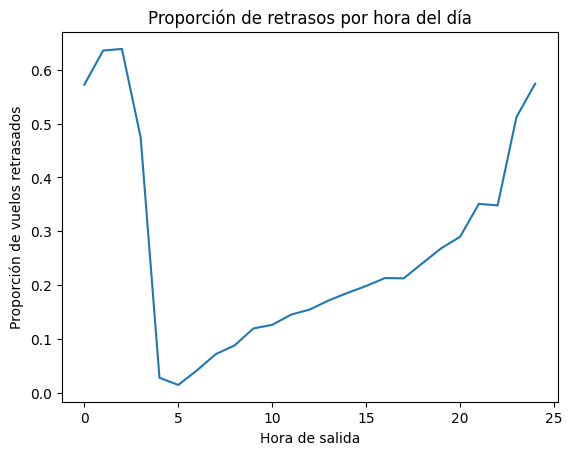

In [ ]:
import matplotlib.pyplot as plt

# Tasa de retraso por hora
delay_by_hour = df.groupby("DEP_HOUR")["RETRASADO"].mean()

plt.figure()
delay_by_hour.plot()
plt.xlabel("Hora de salida")
plt.ylabel("Proporción de vuelos retrasados")
plt.title("Proporción de retrasos por hora del día")
plt.show()


Observamos que la probabilidad de retraso varía según la hora del día, lo que refleja congestión operativa en determinados horarios

###Retrasos por día de la semana

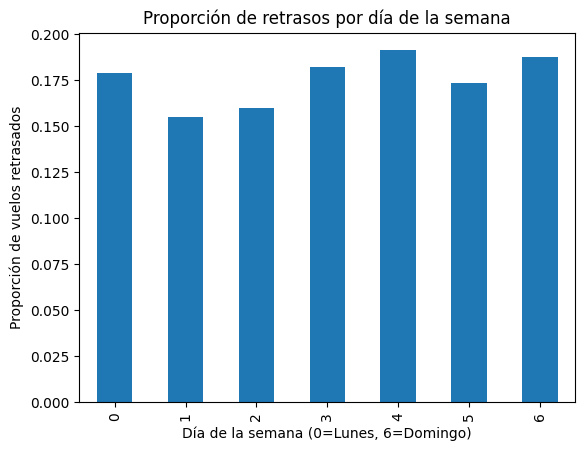

In [ ]:
delay_by_day = df.groupby("DAY_OF_WEEK")["RETRASADO"].mean()

plt.figure()
delay_by_day.plot(kind="bar")
plt.xlabel("Día de la semana (0=Lunes, 6=Domingo)")
plt.ylabel("Proporción de vuelos retrasados")
plt.title("Proporción de retrasos por día de la semana")
plt.show()


El análisis por día de la semana muestra diferencias en el riesgo de retraso, lo que confirma que los patrones temporales influyen en la puntualidad.

###Aerolíneas más frecuentes y su tasa de retraso

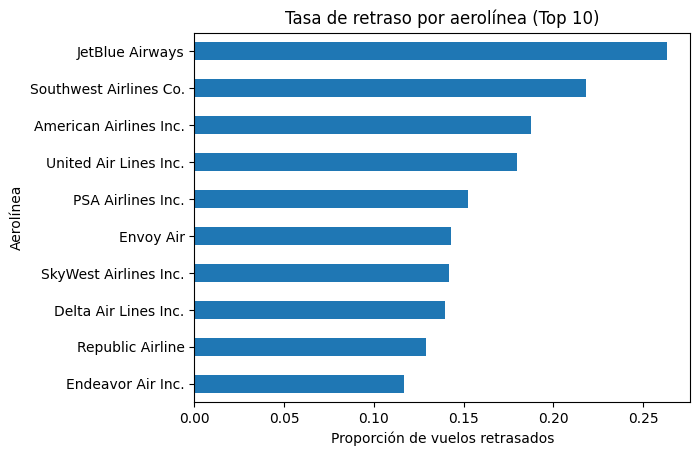

In [ ]:
# Top 10 aerolíneas por número de vuelos
top_airlines = df["AIRLINE"].value_counts().head(10).index

delay_by_airline = (
    df[df["AIRLINE"].isin(top_airlines)]
    .groupby("AIRLINE")["RETRASADO"]
    .mean()
    .sort_values()
)

plt.figure()
delay_by_airline.plot(kind="barh")
plt.xlabel("Proporción de vuelos retrasados")
plt.ylabel("Aerolínea")
plt.title("Tasa de retraso por aerolínea (Top 10)")
plt.show()


También analizamos el comportamiento por aerolínea, observando diferencias en la tasa de retraso entre las compañías con mayor volumen de vuelos

##GRÁFICA INTERACTIVA

In [ ]:
import plotly.express as px

delay_by_hour_df = (
    df.groupby("DEP_HOUR")["RETRASADO"]
    .mean()
    .reset_index()
)

fig = px.line(
    delay_by_hour_df,
    x="DEP_HOUR",
    y="RETRASADO",
    title="Proporción de retrasos por hora del día",
    labels={
        "DEP_HOUR": "Hora de salida",
        "RETRASADO": "Probabilidad de retraso"
    }
)

fig.show()


Adicionalmente, incorporamos una visualización interactiva para explorar cómo varía la probabilidad de retraso según la hora del día, lo que facilita la interpretación de los patrones operativos

#Selección final de variables (features)

In [ ]:
# Variables seleccionadas para el modelo
features = [
    "DEP_HOUR",
    "DAY_OF_WEEK",
    "IS_WEEKEND",
    "DISTANCE",
    "TAXI_OUT",
    "AIRLINE"
]

X = df[features]
y = df["RETRASADO"]

X.head(), y.head()


(   DEP_HOUR  DAY_OF_WEEK  IS_WEEKEND  DISTANCE  TAXI_OUT  \
 0        11            2           0    1065.0      19.0   
 1        21            5           1    1399.0       9.0   
 2        10            4           0     680.0      20.0   
 3        16            0           0    1589.0      27.0   
 4        18            6           1     985.0      15.0   
 
                  AIRLINE  
 0  United Air Lines Inc.  
 1   Delta Air Lines Inc.  
 2  United Air Lines Inc.  
 3   Delta Air Lines Inc.  
 4       Spirit Air Lines  ,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: RETRASADO, dtype: int64)

Seleccionamos un conjunto reducido de variables que representan factores operativos reales y que están disponibles antes del despegue. Esto garantiza que el modelo sea explicable y fácilmente integrable con la API

#Preparación del dataset para Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Columnas categóricas y numéricas
cat_features = ["AIRLINE"]
num_features = [
    "DEP_HOUR",
    "DAY_OF_WEEK",
    "IS_WEEKEND",
    "DISTANCE",
    "TAXI_OUT"
]

# Preprocesador: OneHot solo para AIRLINE
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
        ("num", "passthrough", num_features)
    ]
)

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((2336688, 6), (584172, 6))

In [ ]:
import numpy as np
import joblib
print("Versión de numpy:", np.__version__)
print("Versión de joblib:", joblib.__version__)
import sklearn
print("Versión de scikit-learn:", sklearn.__version__)

Versión de numpy: 2.0.2
Versión de joblib: 1.5.3
Versión de scikit-learn: 1.6.1


###Cantidad de Aerolineas Diferentes

In [ ]:
X["AIRLINE"].nunique()


18

Preparamos el dataset para Machine Learning utilizando un pipeline de preprocesamiento que codifica únicamente las variables categóricas necesarias y mantiene las variables numéricas sin transformación. Esto garantiza reproducibilidad y facilita la integración con el backend.

#Modelo base: Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Pipeline completo: preprocesamiento + modelo
model_lr = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            max_iter=1000,
            n_jobs=-1,
            class_weight="balanced"
        ))
    ]
)

# Entrenar modelo
model_lr.fit(X_train, y_train)

# Predicciones
y_pred_lr = model_lr.predict(X_test)

# Métricas
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

accuracy_lr, report_lr


(0.6339365803222339,
 '              precision    recall  f1-score   support\n\n           0       0.89      0.63      0.74    481570\n           1       0.27      0.63      0.38    102602\n\n    accuracy                           0.63    584172\n   macro avg       0.58      0.63      0.56    584172\nweighted avg       0.78      0.63      0.68    584172\n')

Como modelo base entrenamos una Regresión Logística, que nos permite tener una referencia clara y fácilmente interpretable del desempeño del sistema. Este modelo nos ayuda a entender si las variables seleccionadas capturan correctamente el riesgo de retraso.

El modelo base logra identificar aproximadamente el 63 % de los vuelos retrasados. Dado el desbalance natural de los datos, priorizamos el recall para no dejar pasar vuelos con alto riesgo de retraso, aun a costa de una menor precisión

#Modelo final: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline completo: preprocesamiento + Random Forest
model_rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced"
        ))
    ]
)

# Entrenar modelo
model_rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = model_rf.predict(X_test)

# Métricas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

accuracy_rf, report_rf


(0.6568664708339325,
 '              precision    recall  f1-score   support\n\n           0       0.90      0.66      0.76    481570\n           1       0.29      0.64      0.39    102602\n\n    accuracy                           0.66    584172\n   macro avg       0.59      0.65      0.58    584172\nweighted avg       0.79      0.66      0.70    584172\n')

Probamos dos enfoques: un modelo base con Regresión Logística y un modelo más robusto con Random Forest. El Random Forest mostró una mejora consistente en accuracy, recall y F1-score, por lo que fue seleccionado como el modelo final para el MVP

#Importancia de variables (explicabilidad)

In [ ]:
# Obtener nombres de variables después del preprocesamiento
feature_names = (
    model_rf.named_steps["preprocessor"]
    .get_feature_names_out()
)

# Importancia de variables
importances = model_rf.named_steps["classifier"].feature_importances_

importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(10)
)

importance_df


,feature,importance
18,num__DEP_HOUR,0.648442
21,num__DISTANCE,0.125062
22,num__TAXI_OUT,0.101277
15,cat__AIRLINE_Southwest Airlines Co.,0.026424
19,num__DAY_OF_WEEK,0.020334
3,cat__AIRLINE_Delta Air Lines Inc.,0.013761
10,cat__AIRLINE_JetBlue Airways,0.013336
4,cat__AIRLINE_Endeavor Air Inc.,0.008201
14,cat__AIRLINE_SkyWest Airlines Inc.,0.008155
7,cat__AIRLINE_Frontier Airlines Inc.,0.007065


Analizamos la importancia de las variables del modelo y observamos que la hora de salida es el factor más influyente en la predicción de retrasos, seguida por la distancia del vuelo y el tiempo de taxi. Además, algunas aerolíneas presentan patrones operativos distintos que el modelo logra capturar. Esto nos permite explicar las predicciones de forma clara y transparente.

#Exportación del modelo

In [ ]:
import joblib

bundle = {
    "model": model_rf,
    "expected_columns": X.columns.tolist()
}

joblib.dump(bundle, "/content/drive/MyDrive/Colab Notebooks/Hackaton/Datos/flight_delay_model_backend.pkl")


['/content/drive/MyDrive/Colab Notebooks/Hackaton/Datos/flight_delay_model_backend.pkl']

Entregamos un modelo predictivo entrenado con datos históricos de vuelos, evaluado con métricas estándar y exportado junto con su pipeline de preprocesamiento. El modelo está listo para ser integrado directamente en la API del backend.

###TRANSFORMACION PKL A OXXN

In [ ]:
import sklearn
print("Versión de scikit-learn:", sklearn.__version__)
import numpy as np
import joblib
print("Versión de numpy:", np.__version__)
print("Versión de joblib:", joblib.__version__)

Versión de scikit-learn: 1.6.1
Versión de numpy: 2.0.2
Versión de joblib: 1.5.3


In [ ]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 43.9 MB/s eta 0:00:00


In [ ]:
import joblib

# Carga el bundle
bundle = joblib.load("/content/drive/MyDrive/Colab Notebooks/Hackaton/Datos/flight_delay_model_backend.pkl")
model = bundle["model"]
expected_columns = bundle["expected_columns"]

print("Columnas esperadas:", expected_columns)
print("Modelo (Pipeline):", model)
print("Pasos del Pipeline:", model.steps)  # Esto te dirá si hay ColumnTransformer

Columnas esperadas: ['DEP_HOUR', 'DAY_OF_WEEK', 'IS_WEEKEND', 'DISTANCE', 'TAXI_OUT', 'AIRLINE']
Modelo (Pipeline): Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['AIRLINE']),
                                                 ('num', 'passthrough',
                                                  ['DEP_HOUR', 'DAY_OF_WEEK',
                                                   'IS_WEEKEND', 'DISTANCE',
                                                   'TAXI_OUT'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_jobs=-1, random_state=42))])
Pasos del Pipeline: [('preprocessor', ColumnTransformer(transformers=[('cat',
 

###Análisis de modelo y columnas

*   Columnas esperadas: ['DEP_HOUR', 'DAY_OF_WEEK', 'IS_WEEKEND',

*   'DISTANCE', 'TAXI_OUT', 'AIRLINE']
Todas parecen numéricas excepto 'AIRLINE', que es categórica (string), ya que el ColumnTransformer la procesa con OneHotEncoder en el paso 'cat'.

*   Las demás ('DEP_HOUR', 'DAY_OF_WEEK', 'IS_WEEKEND', 'DISTANCE', 'TAXI_OUT') pasan directamente ('passthrough') en el paso 'num', lo que indica que son numéricas (float).

*   Modelo (Pipeline): Tiene dos pasos principales:
'preprocessor': ColumnTransformer que separa 'AIRLINE' (categórica) para codificarla, y las numéricas pasan sin cambios.
'classifier': RandomForestClassifier.


In [ ]:
import joblib
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType

# Carga el bundle
bundle = joblib.load("/content/drive/MyDrive/Colab Notebooks/Hackaton/Datos/flight_delay_model_backend.pkl")
model = bundle["model"]
expected_columns = bundle["expected_columns"]

# Define initial_types con los nombres de las columnas
# 'AIRLINE' es string (categórica), las demás son float (numéricas)
string_columns = ['AIRLINE']
initial_types = []
for col in expected_columns:
    if col in string_columns:
        initial_types.append((col, StringTensorType([None, 1])))
    else:
        initial_types.append((col, FloatTensorType([None, 1])))

print("Initial types definidos:", initial_types)  # Para verificar

# Convierte a ONNX
onnx_model = convert_sklearn(model, initial_types=initial_types)

# Guarda ONNX
with open("/content/drive/MyDrive/Colab Notebooks/Hackaton/Datos/flight_delay_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("¡Conversión exitosa!")

Initial types definidos: [('DEP_HOUR', FloatTensorType(shape=[None, 1])), ('DAY_OF_WEEK', FloatTensorType(shape=[None, 1])), ('IS_WEEKEND', FloatTensorType(shape=[None, 1])), ('DISTANCE', FloatTensorType(shape=[None, 1])), ('TAXI_OUT', FloatTensorType(shape=[None, 1])), ('AIRLINE', StringTensorType(shape=[None, 1]))]
¡Conversión exitosa!


###Explicación

*   initial_types: Crea una lista de tuplas como [('DEP_HOUR',  FloatTensorType([None, 1])), ('AIRLINE', StringTensorType([None, 1])), ...]. Esto mapea cada columna a su tipo, permitiendo que skl2onnx procese el ColumnTransformer correctamente.

*   [None, 1]: Significa "batch variable (None)" y "1 característica por columna".